In [1]:
import sys
import pathlib

# Ajouter le dossier racine du projet (celui qui contient src/) au PYTHONPATH
root_path = pathlib.Path().resolve().parent  # remonte d’un dossier depuis notebooks/
sys.path.append(str(root_path))


In [3]:
# from src.data.make_dataset import download_kaggle_data
# download_kaggle_data()

Étape 1 : Importation des bibliothèques nécessaires
Objectif : Importer les outils nécessaires pour le traitement des données, la visualisation, et l’analyse statistique.

Actions :

Importer pandas, numpy pour le traitement des données.
Importer matplotlib, seaborn pour les visualisations.
Importer statsmodels pour les p-values.
Importer sklearn.preprocessing pour la standardisation.
Configurer un logger pour suivre les étapes.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import ppscore as pps

# Configurer le logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurer le style des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

logger.info("Bibliothèques importées et logger configuré")

TARGET_NAME = "SalePrice"
SEED = 42
MIN_CORR_COEF = 1.5
MIN_PPS = 0.1

c:\Users\USER\anaconda3\envs\house_price_env\lib\site-packages\ppscore\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-07-30 14:41:25,320 - INFO - Bibliothèques importées et logger configuré


Étape 2 : Chargement des données
Objectif : Charger les datasets train.csv et test.csv, supprimer la colonne Id (non informative), et afficher un aperçu pour vérifier la structure.

Actions :

Charger les fichiers depuis le répertoire spécifié.
Supprimer Id des deux datasets.
Stocker test_ids pour les soumissions Kaggle.
Afficher les dimensions et les 5 premières lignes.

In [ ]:
# Définir le répertoire des données
DATA_DIR = Path("./../src/data/")

# Charger les données
train = pd.read_csv(DATA_DIR / "raw/train.csv")
test = pd.read_csv(DATA_DIR / "raw/test.csv")
test_ids = test['Id']
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

# Afficher les dimensions et un aperçu
logger.info(f"Dimensions train : {train.shape}")
logger.info(f"Dimensions test : {test.shape}")
display(train.head())
display(test.head())

2025-07-30 12:57:33,251 - INFO - Dimensions train : (1460, 80)
2025-07-30 12:57:33,251 - INFO - Dimensions test : (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Exploration des types de données
Objectif : Identifier les types de données (numériques, catégoriques) pour planifier le prétraitement.

Actions :

Lister les colonnes numériques et catégoriques.
Afficher un résumé des types avec info().
Visualiser la répartition des types via un barplot.

In [6]:
# Lister les colonnes par type
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

logger.info(f"Colonnes numériques ({len(numeric_cols)}) : {list(numeric_cols)}")
logger.info(f"Colonnes catégoriques ({len(categorical_cols)}) : {list(categorical_cols)}")



2025-07-30 12:57:50,400 - INFO - Colonnes numériques (37) : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
2025-07-30 12:57:50,400 - INFO - Colonnes catégoriques (43) : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Hea

In [7]:
# Résumé des types
logger.info("Résumé des types de données :")
train.info()



2025-07-30 12:57:58,066 - INFO - Résumé des types de données :


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

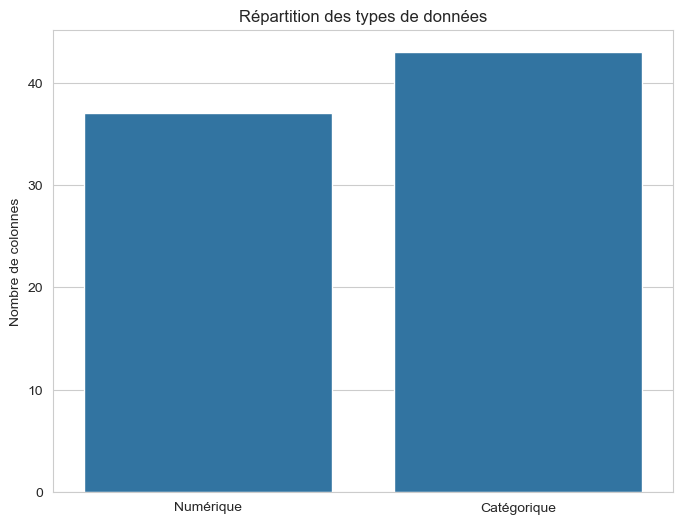

In [8]:
# Visualiser la répartition des types
type_counts = {'Numérique': len(numeric_cols), 'Catégorique': len(categorical_cols)}
plt.figure(figsize=(8, 6))
sns.barplot(x=list(type_counts.keys()), y=list(type_counts.values()))
plt.title("Répartition des types de données")
plt.ylabel("Nombre de colonnes")
plt.show()

### Analyse des valeurs manquantes
Objectif : Identifier les colonnes avec des valeurs manquantes pour planifier leur gestion (imputation ou suppression).

Actions :

Calculer le pourcentage de valeurs manquantes par colonne.
Afficher les colonnes avec des valeurs manquantes (>0%).
Visualiser via un barplot et une heatmap.

2025-07-30 12:58:35,000 - INFO - Pourcentage de valeurs manquantes par colonne :


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

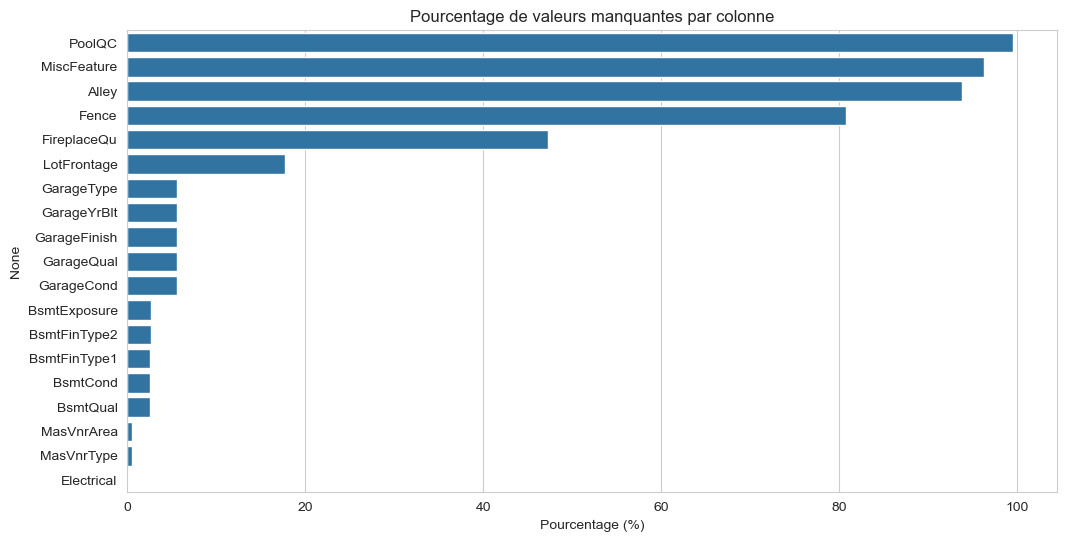

In [9]:
# Calculer le pourcentage de valeurs manquantes
missing_values = train.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

logger.info("Pourcentage de valeurs manquantes par colonne :")
display(missing_values)

# Visualiser via un barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title("Pourcentage de valeurs manquantes par colonne")
plt.xlabel("Pourcentage (%)")
plt.show()


### Feature engineering
Objectif : Créer 4 nouvelles features pertinentes pour améliorer la prédiction, visualiser leurs distributions et relations avec SalePrice.

Actions :

Créer HouseAge, TotalSF, TotalBathrooms, OverallQualityCond.
Afficher un histogramme de SalePrice.
Afficher des scatter plots pour chaque nouvelle feature vs SalePrice.
Décrire le calcul et la pertinence de chaque feature.
Nouvelles features :


*Nouvelles features*:

- *HouseAge*:
  - *Formule*: YrSold - YearBuilt
  - *Pertinence*: L’âge de la maison influence le prix (corrélation ~ -0.5).
  - *Exemple*: Si YrSold = 2008 et YearBuilt = 1980, alors HouseAge = 28.

- *TotalSF*:
  - *Formule*: 1stFlrSF + 2ndFlrSF + TotalBsmtSF
  - *Pertinence*: La surface totale habitable est fortement corrélée (~0.7) avec SalePrice.
  - *Exemple*: Si 1stFlrSF = 1000, 2ndFlrSF = 500, TotalBsmtSF = 800, alors TotalSF = 2300.

- *TotalBathrooms*:
  - *Formule*: FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath
  - *Pertinence*: Combine toutes les salles de bain, corrélation ~0.5-0.6.
  - *Exemple*: Si FullBath = 2, HalfBath = 1, BsmtFullBath = 1, BsmtHalfBath = 0, alors TotalBathrooms = 3.5.


In [15]:
# Créer des features
train = train.assign(building_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearBuilt.astype(float),
                   remodel_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearRemodAdd.astype(float),
                   garage_age=lambda dfr: dfr.YrSold.astype(float) - dfr.GarageYrBlt.astype(float),
                   total_sf=lambda dfr: dfr["1stFlrSF"] + dfr["2ndFlrSF"] + dfr["TotalBsmtSF"],
                   total_bathrooms=lambda dfr: dfr.FullBath + 0.5 * dfr.HalfBath + dfr.BsmtFullBath + 0.5 * dfr.BsmtHalfBath
                  )
train.head()



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,building_age,remodel_age,garage_age,total_sf,total_bathrooms
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,208500,5.0,5.0,5.0,2566,3.5
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,5,2007,WD,Normal,181500,31.0,31.0,31.0,2524,2.5
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,9,2008,WD,Normal,223500,7.0,6.0,7.0,2706,3.5
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,2,2006,WD,Abnorml,140000,91.0,36.0,8.0,2473,2.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,12,2008,WD,Normal,250000,8.0,8.0,8.0,3343,3.5


In [ ]:

test = test.assign(building_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearBuilt.astype(float),
                   remodel_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearRemodAdd.astype(float),
                   garage_age=lambda dfr: dfr.YrSold.astype(float) - dfr.GarageYrBlt.astype(float),
                   total_sf=lambda dfr: dfr.TotalBsmtSF + dfr.GrLivArea + dfr.GarageArea,
                   total_bathrooms=lambda dfr: dfr.FullBath + 0.5 * dfr.HalfBath + dfr.BsmtFullBath + 0.5 * dfr.BsmtHalfBath
                  )
test.head()
 

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,building_age,remodel_age,garage_age,total_sf,total_bathrooms
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,6,2010,WD,Normal,49.0,49.0,49.0,2508.0,1.0
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,12500,6,2010,WD,Normal,52.0,52.0,52.0,2970.0,1.5
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,3,2010,WD,Normal,13.0,12.0,13.0,3039.0,2.5
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,6,2010,WD,Normal,12.0,12.0,12.0,3000.0,2.5
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,1,2010,WD,Normal,18.0,18.0,18.0,3066.0,2.0


In [40]:
redundant_cols = [
     'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
    '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

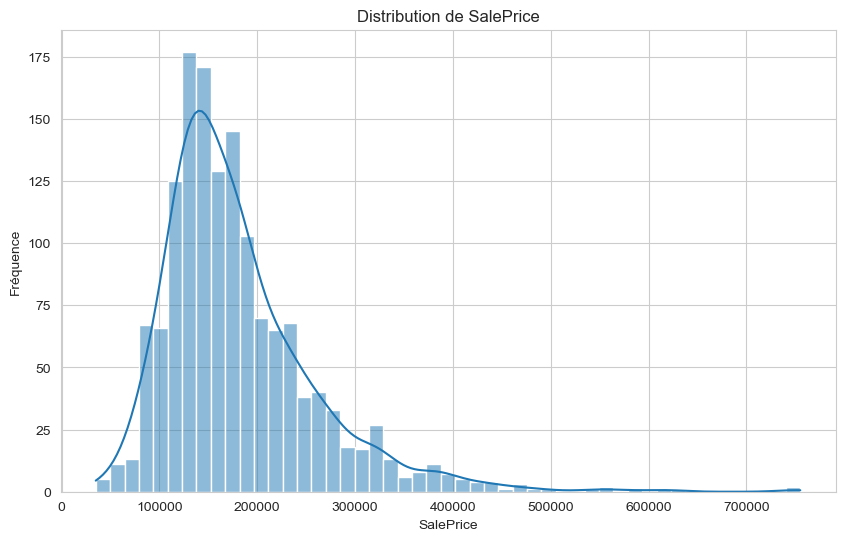

In [19]:
# Afficher la distribution de SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True)
plt.title("Distribution de SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Fréquence")
plt.show()

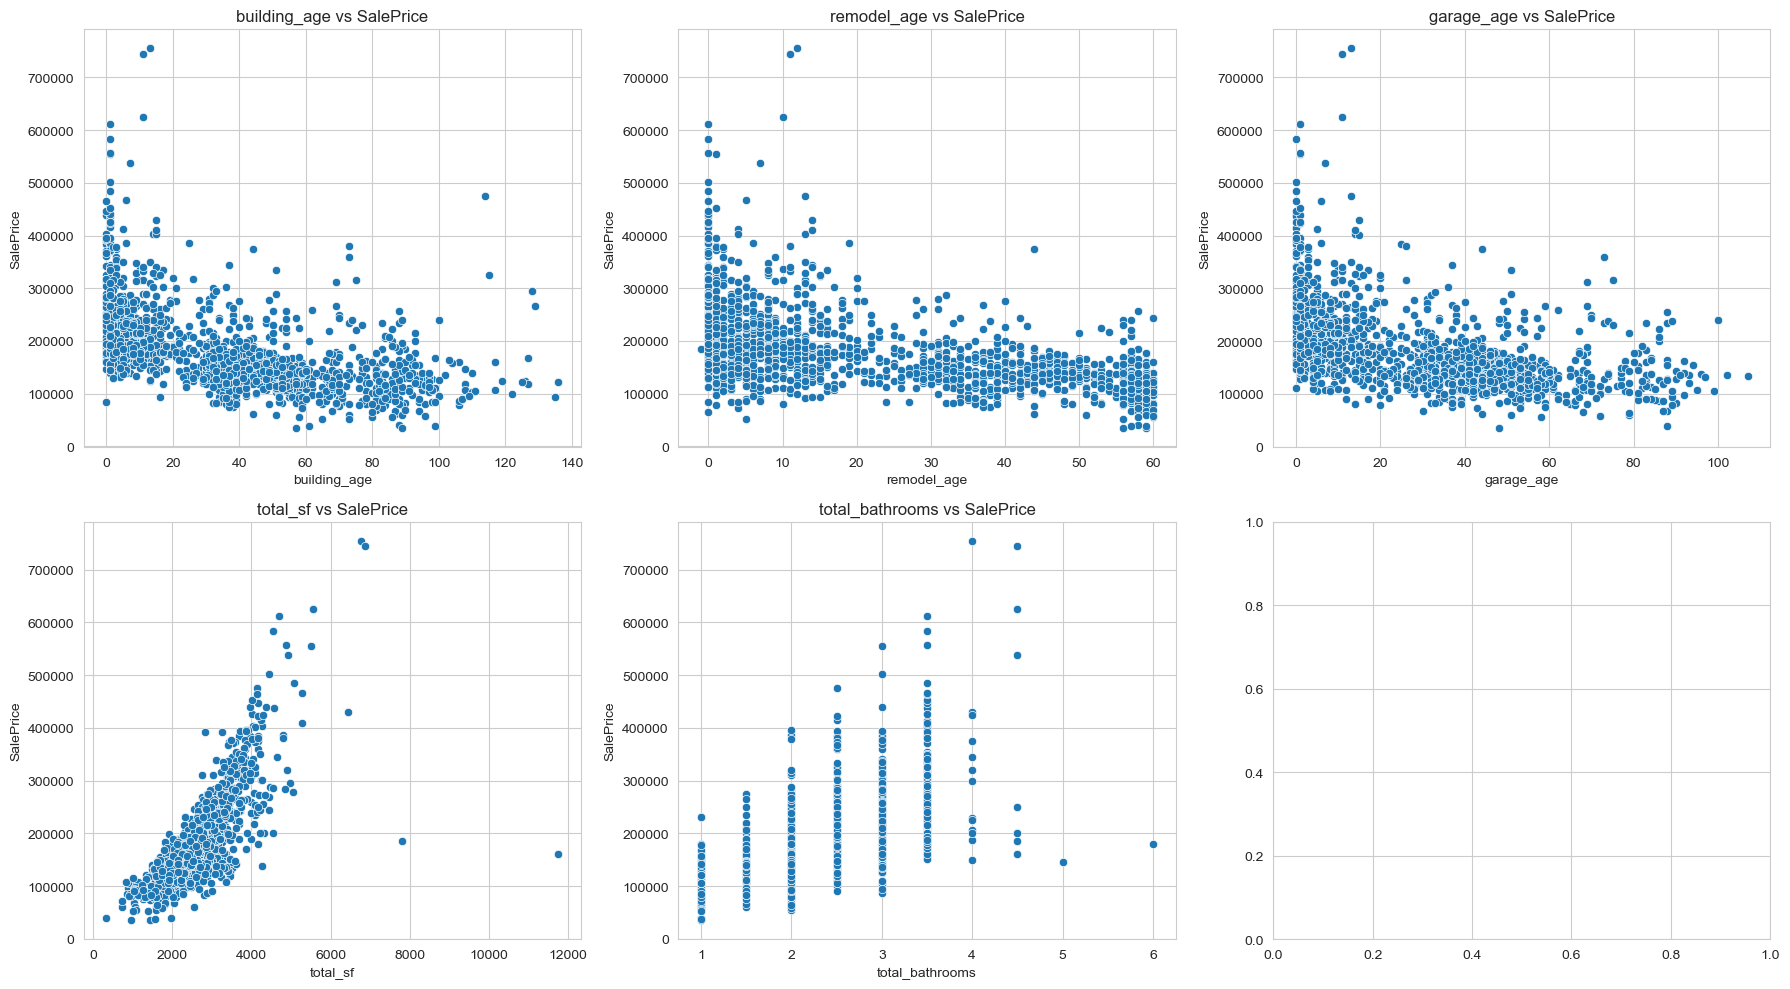

In [20]:
# Scatter plots pour visualiser la relation avec SalePrice
new_features = ['building_age', 'remodel_age', 'garage_age', 'total_sf', 'total_bathrooms']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 lignes, 3 colonnes
axes = axes.flatten()  # Rend les axes accessibles comme une liste

for i, feature in enumerate(new_features):
    sns.scatterplot(x=train[feature], y=train['SalePrice'], ax=axes[i])
    axes[i].set_title(f"{feature} vs SalePrice")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("SalePrice")

plt.tight_layout()
plt.show()


### Matrice de corrélation avec nouvelles features
Objectif : Évaluer l’impact des nouvelles features sur les corrélations avec SalePrice.

Actions :

Recalculer la matrice de corrélation avec les nouvelles features.
Afficher une heatmap.
Lister les corrélations avec SalePrice.

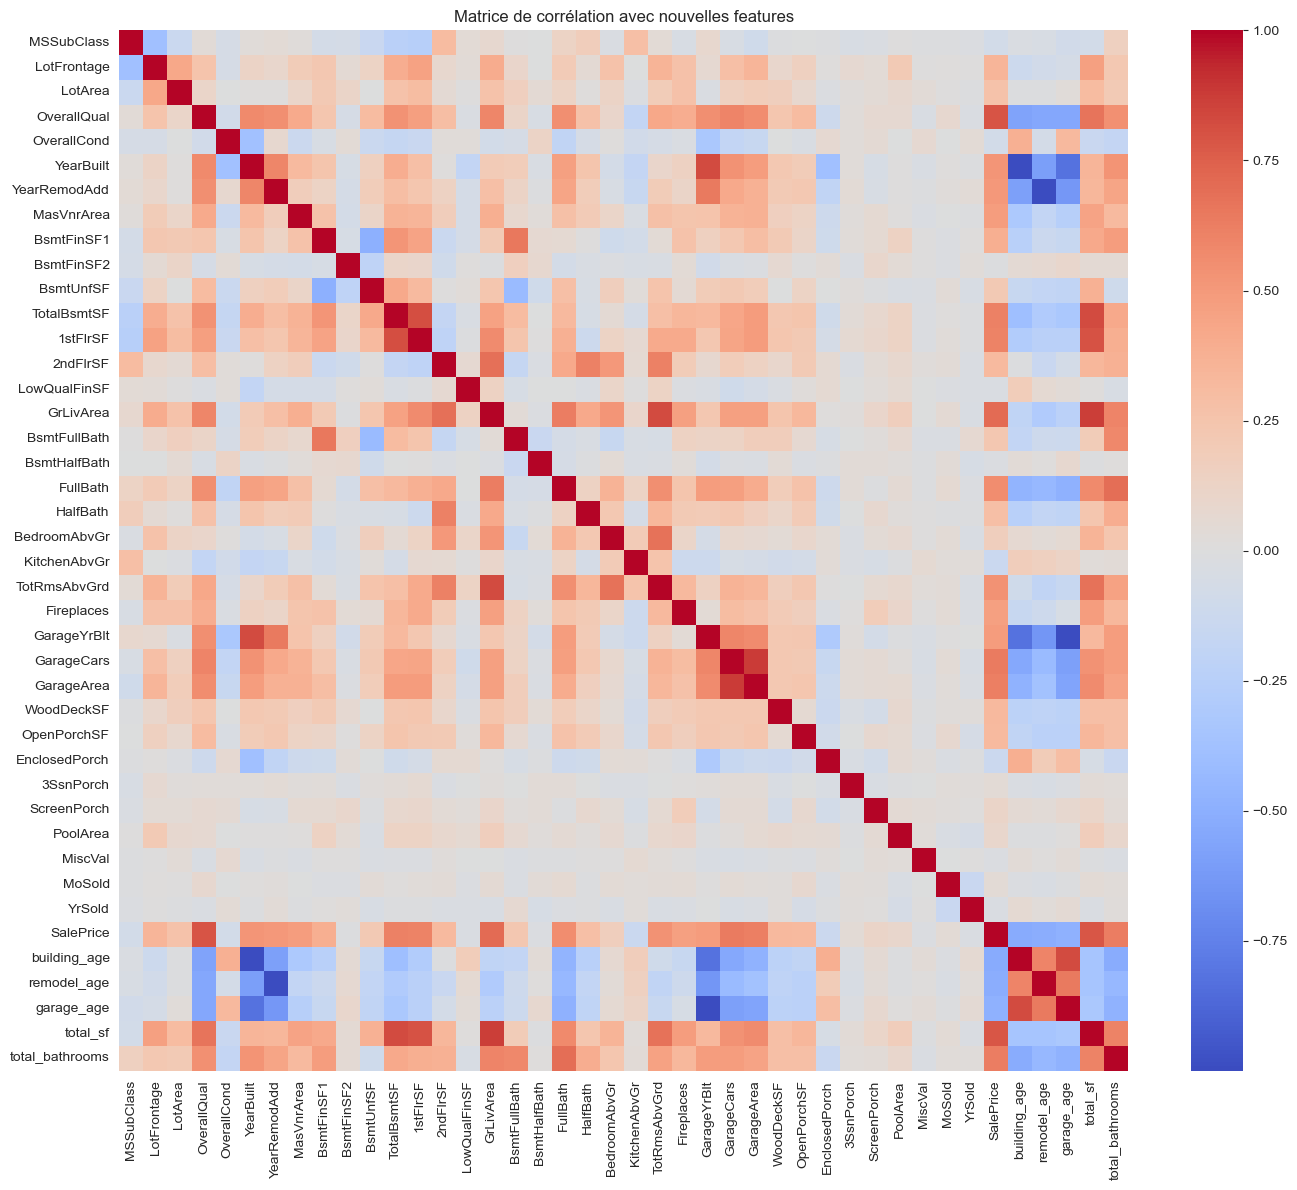

2025-07-30 13:20:17,744 - INFO - Corrélations avec SalePrice (toutes) :


SalePrice          1.000000
OverallQual        0.790982
total_sf           0.782260
GrLivArea          0.708624
GarageCars         0.640409
total_bathrooms    0.631731
GarageArea         0.623431
TotalBsmtSF        0.613581
1stFlrSF           0.605852
FullBath           0.560664
TotRmsAbvGrd       0.533723
YearBuilt          0.522897
YearRemodAdd       0.507101
GarageYrBlt        0.486362
MasVnrArea         0.477493
Fireplaces         0.466929
BsmtFinSF1         0.386420
LotFrontage        0.351799
WoodDeckSF         0.324413
2ndFlrSF           0.319334
OpenPorchSF        0.315856
HalfBath           0.284108
LotArea            0.263843
BsmtFullBath       0.227122
BsmtUnfSF          0.214479
BedroomAbvGr       0.168213
ScreenPorch        0.111447
PoolArea           0.092404
MoSold             0.046432
3SsnPorch          0.044584
BsmtFinSF2        -0.011378
BsmtHalfBath      -0.016844
MiscVal           -0.021190
LowQualFinSF      -0.025606
YrSold            -0.028923
OverallCond       -0

In [23]:

numeric_cols = train.select_dtypes(include=['int64', 'float64', 'int32']).columns
numeric_cols_with_target = numeric_cols  # Conserver comme Index, pas une liste
correlation_matrix = train[numeric_cols_with_target].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation avec nouvelles features")
plt.tight_layout()
plt.show()

saleprice_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)
logger.info("Corrélations avec SalePrice (toutes) :")
display(saleprice_corr)

Features selection avec Corr

In [41]:
# collones à retenir ap

CORR_COLS = saleprice_corr[abs(saleprice_corr) > 0.15].index
logger.info(f"Variables avec |corr| > 0.15 : {list(CORR_COLS)}")

CORR_COLS = [item for item in CORR_COLS if item not in redundant_cols and item != TARGET_NAME and item != 'Id']

2025-07-30 14:42:24,008 - INFO - Variables avec |corr| > 0.15 : ['SalePrice', 'OverallQual', 'total_sf', 'GrLivArea', 'GarageCars', 'total_bathrooms', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'garage_age', 'remodel_age', 'building_age']


In [42]:
len(CORR_COLS)

19

### PPSCORES

In [44]:
# Predictive Power Score (PPS) : https://github.com/8080labs/ppscore/
#
pps_predictors = pps.predictors(df=train.drop(redundant_cols, axis=1),
                                y=TARGET_NAME, output="df", random_seed=SEED)
pps_predictors

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,OverallQual,SalePrice,0.444021,regression,True,mean absolute error,55533.656164,30875.568225,DecisionTreeRegressor()
1,Neighborhood,SalePrice,0.337573,regression,True,mean absolute error,55533.656164,36786.967628,DecisionTreeRegressor()
2,GarageCars,SalePrice,0.298869,regression,True,mean absolute error,55533.656164,38936.361994,DecisionTreeRegressor()
3,ExterQual,SalePrice,0.275945,regression,True,mean absolute error,55533.656164,40209.410056,DecisionTreeRegressor()
4,BsmtQual,SalePrice,0.267740,regression,True,mean absolute error,55400.797611,40567.772895,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...,...
68,PoolArea,SalePrice,0.000000,regression,True,mean absolute error,55533.656164,58131.426647,DecisionTreeRegressor()
69,PoolQC,SalePrice,0.000000,regression,True,mean absolute error,108281.428571,185801.250000,DecisionTreeRegressor()
70,MiscFeature,SalePrice,0.000000,regression,True,mean absolute error,40320.500000,42405.938655,DecisionTreeRegressor()
71,MiscVal,SalePrice,0.000000,regression,True,mean absolute error,55533.656164,57648.226323,DecisionTreeRegressor()


Feature selection avec ppscore

In [45]:
#
PPS_COLS = pps_predictors.loc[pps_predictors.ppscore >= MIN_PPS, "x"].values
set(PPS_COLS)

{'Alley',
 'BsmtQual',
 'ExterQual',
 'Foundation',
 'GarageArea',
 'GarageCars',
 'GarageFinish',
 'GarageType',
 'GrLivArea',
 'KitchenQual',
 'MSSubClass',
 'Neighborhood',
 'OverallQual',
 'TotRmsAbvGrd',
 'building_age',
 'garage_age',
 'remodel_age',
 'total_bathrooms',
 'total_sf'}

In [46]:
len(PPS_COLS)

19

In [50]:
FEATURES_NAMES = set(CORR_COLS) | set(PPS_COLS)
logger.info(f"Features sélectionnées : {list(FEATURES_NAMES)}")

2025-07-30 14:47:46,703 - INFO - Features sélectionnées : ['BedroomAbvGr', 'building_age', 'OpenPorchSF', 'Fireplaces', 'KitchenQual', 'total_bathrooms', 'garage_age', 'LotArea', 'Alley', 'GarageFinish', 'MasVnrArea', 'BsmtQual', 'Foundation', 'OverallQual', 'BsmtFinSF1', 'GarageCars', 'LotFrontage', 'GarageType', 'total_sf', 'WoodDeckSF', 'MSSubClass', 'TotRmsAbvGrd', 'GrLivArea', 'BsmtUnfSF', 'Neighborhood', 'GarageArea', 'ExterQual', 'remodel_age']


In [51]:
len(FEATURES_NAMES)

28

Elimination des collones ayant plus 35% de valeurs manquantes

In [48]:
high_missing_cols = missing_values[missing_values > 35].index
logger.info(f"Colonnes avec >35% de valeurs manquantes : {list(high_missing_cols)}")

2025-07-30 14:46:23,839 - INFO - Colonnes avec >35% de valeurs manquantes : ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


In [54]:
FEATURES_NAMES = [item for item in FEATURES_NAMES if item not in high_missing_cols]
FEATURES_NAMES

['BedroomAbvGr',
 'building_age',
 'OpenPorchSF',
 'Fireplaces',
 'KitchenQual',
 'total_bathrooms',
 'garage_age',
 'LotArea',
 'GarageFinish',
 'MasVnrArea',
 'BsmtQual',
 'Foundation',
 'OverallQual',
 'BsmtFinSF1',
 'GarageCars',
 'LotFrontage',
 'GarageType',
 'total_sf',
 'WoodDeckSF',
 'MSSubClass',
 'TotRmsAbvGrd',
 'GrLivArea',
 'BsmtUnfSF',
 'Neighborhood',
 'GarageArea',
 'ExterQual',
 'remodel_age']

In [55]:
len(FEATURES_NAMES)

27

In [63]:
NEW_CATS_COLS = [item for item in FEATURES_NAMES if item in categorical_cols]
NEW_NUMS_COLS = [item for item in FEATURES_NAMES if item in numeric_cols]

logger.info(f"Colonnes catégoriques retenues : {NEW_CATS_COLS}")
logger.info(f"Colonnes numériques retenues : {NEW_NUMS_COLS}")

2025-07-30 15:05:54,577 - INFO - Colonnes catégoriques retenues : ['KitchenQual', 'GarageFinish', 'BsmtQual', 'Foundation', 'GarageType', 'Neighborhood', 'ExterQual']
2025-07-30 15:05:54,586 - INFO - Colonnes numériques retenues : ['BedroomAbvGr', 'building_age', 'OpenPorchSF', 'Fireplaces', 'total_bathrooms', 'garage_age', 'LotArea', 'MasVnrArea', 'OverallQual', 'BsmtFinSF1', 'GarageCars', 'LotFrontage', 'total_sf', 'WoodDeckSF', 'MSSubClass', 'TotRmsAbvGrd', 'GrLivArea', 'BsmtUnfSF', 'GarageArea', 'remodel_age']


### Feature selection
Objectif : Supprimer les colonnes non pertinentes (valeurs manquantes élevées, faible corrélation, p-value élevé, redondance) pour simplifier le dataset.

Actions :

Supprimer les colonnes avec >50% de valeurs manquantes.
Supprimer les colonnes avec |corr| < 0.1 ou p-value > 0.05.
Supprimer les colonnes redondantes après feature engineering :
YearBuilt (remplacé par HouseAge).
1stFlrSF, 2ndFlrSF, TotalBsmtSF (remplacés par TotalSF).
FullBath, HalfBath, BsmtFullBath, BsmtHalfBath (remplacés par TotalBathrooms).
OverallCond (remplacé par OverallQualityCond).

In [56]:
# # Identifier les colonnes à supprimer
# high_missing_cols = missing_values[missing_values > 50].index
# logger.info(f"Colonnes avec >50% de valeurs manquantes : {list(high_missing_cols)}")

# non_significant_vars = p_values[p_values > 0.05].index
# low_corr_vars = saleprice_corr[abs(saleprice_corr) < 0.1].index
# logger.info(f"Variables avec p-value > 0.05 : {list(non_significant_vars)}")
# logger.info(f"Variables avec |corr| < 0.1 : {list(low_corr_vars)}")

# redundant_cols = [
#     'YearBuilt', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF',
#     'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'OverallCond'
# ]
# logger.info(f"Colonnes redondantes : {redundant_cols}")

# cols_to_drop = list(set(high_missing_cols) | set(non_significant_vars) | set(low_corr_vars) | set(redundant_cols))
# logger.info(f"Colonnes à supprimer : {cols_to_drop}")

# train = train.drop(cols_to_drop, axis=1)
# test = test.drop(cols_to_drop, axis=1)

# logger.info(f"Dimensions train après suppression : {train.shape}")
# logger.info(f"Dimensions test après suppression : {test.shape}")

In [60]:
NEW_TRAIN = train[FEATURES_NAMES + [TARGET_NAME]].copy()
NEW_TEST = test[FEATURES_NAMES].copy()

### Gestion des valeurs manquantes restantes
Objectif : Imputer les valeurs manquantes restantes pour obtenir un dataset complet.

Actions :

Imputer les variables catégoriques avec "None".
Imputer les variables numériques avec la médiane (robuste aux outliers).
Vérifier l’absence de valeurs manquantes via une heatmap.

In [61]:
logger.info(f"Dimensions NEW_TRAIN : {NEW_TRAIN.shape}")
logger.info(f"Dimensions NEW_TEST : {NEW_TEST.shape}")

2025-07-30 15:02:28,731 - INFO - Dimensions NEW_TRAIN : (1460, 28)
2025-07-30 15:02:28,731 - INFO - Dimensions NEW_TEST : (1459, 27)


In [65]:
# afficher des valeurs manquantes de notrre nouveau dataset
logger.info("Valeurs manquantes dans le nouveau train :")
display(NEW_TRAIN.isnull().sum()[NEW_TRAIN.isnull().sum() > 0])
logger.info("Valeurs manquantes dans le nouveau test :")
display(NEW_TEST.isnull().sum()[NEW_TEST.isnull().sum() > 0])

2025-07-30 15:09:38,859 - INFO - Valeurs manquantes dans le nouveau train :


garage_age       81
GarageFinish     81
MasVnrArea        8
BsmtQual         37
LotFrontage     259
GarageType       81
dtype: int64

2025-07-30 15:09:38,878 - INFO - Valeurs manquantes dans le nouveau test :


KitchenQual          1
total_bathrooms      2
garage_age          78
GarageFinish        78
MasVnrArea          15
BsmtQual            44
BsmtFinSF1           1
GarageCars           1
LotFrontage        227
GarageType          76
total_sf             2
BsmtUnfSF            1
GarageArea           1
dtype: int64

In [66]:

# Imputer les valeurs manquantes
for col in NEW_CATS_COLS:
    NEW_TRAIN[col] = NEW_TRAIN[col].fillna("None")
    NEW_TEST[col] = NEW_TEST[col].fillna("None")
for col in NEW_NUMS_COLS:
    NEW_TRAIN[col] = NEW_TRAIN[col].fillna(NEW_TRAIN[col].median())
    NEW_TEST[col] = NEW_TEST[col].fillna(NEW_TEST[col].median())


In [67]:
# Vérifier l'absence de valeurs manquantes
logger.info("Valeurs manquantes restantes dans train :")
display(NEW_TRAIN.isnull().sum()[NEW_TRAIN.isnull().sum() > 0].count())
logger.info("Valeurs manquantes restantes dans test :")
display(NEW_TEST.isnull().sum()[NEW_TEST.isnull().sum() > 0].count())

2025-07-30 15:09:47,020 - INFO - Valeurs manquantes restantes dans train :


0

2025-07-30 15:09:47,060 - INFO - Valeurs manquantes restantes dans test :


0

### Analyse des outliers
Objectif : Identifier et gérer les outliers pour les 5 variables les plus corrélées avec SalePrice pour éviter les biais dans la modélisation.

Actions :

Identifier les 5 variables les plus corrélées (via saleprice_corr).
Afficher leurs boxplots.
Définir des seuils pour supprimer les outliers (basés sur les boxplots).
Supprimer les lignes avec outliers.
Afficher les boxplots après suppression.

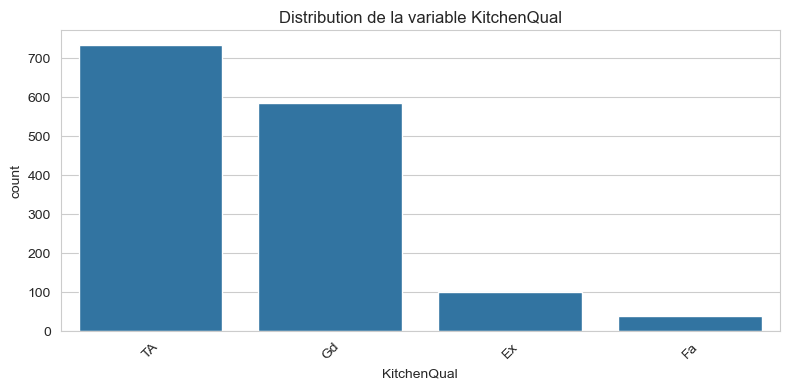

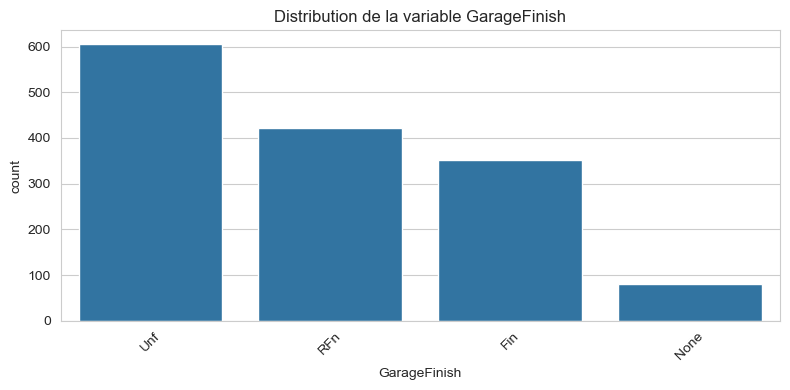

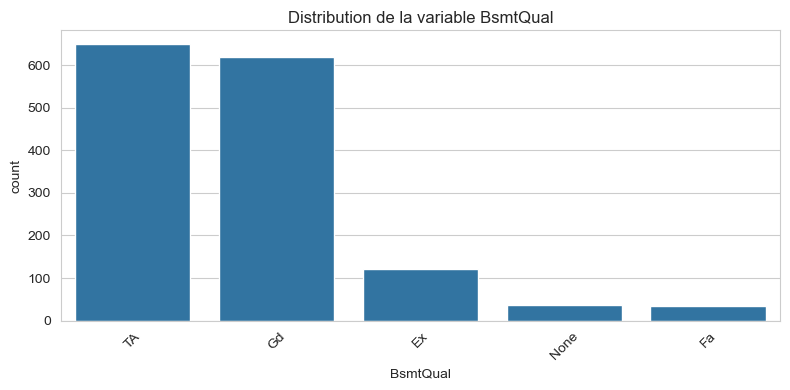

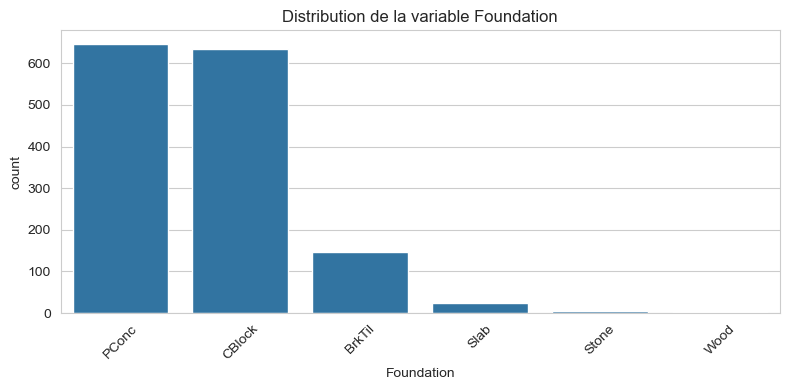

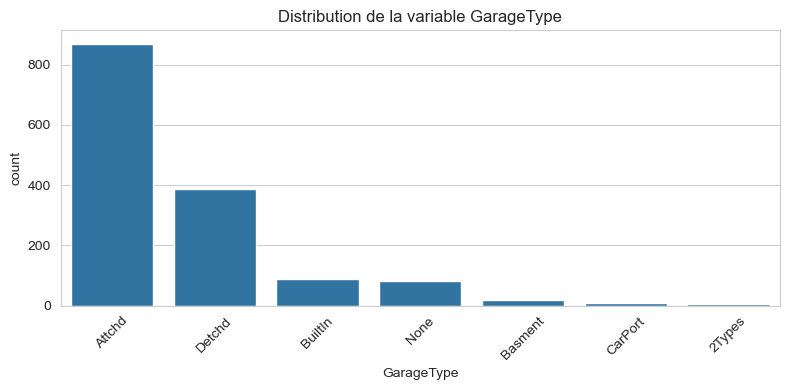

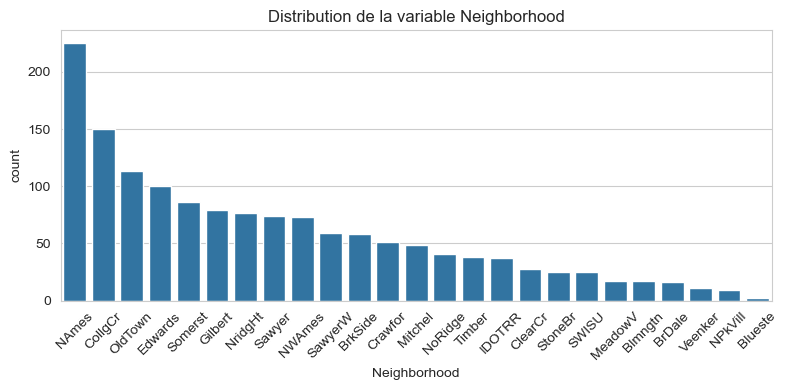

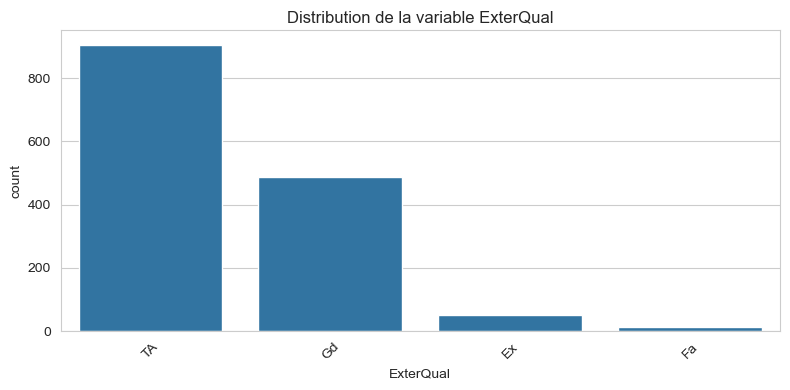

In [ ]:
# Visualisation de la répartition des variables catégorielles
for col in NEW_CATS_COLS:
    if col in NEW_TRAIN.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=NEW_TRAIN, x=col, order=NEW_TRAIN[col].value_counts().index)
        plt.title(f'Distribution de la variable {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

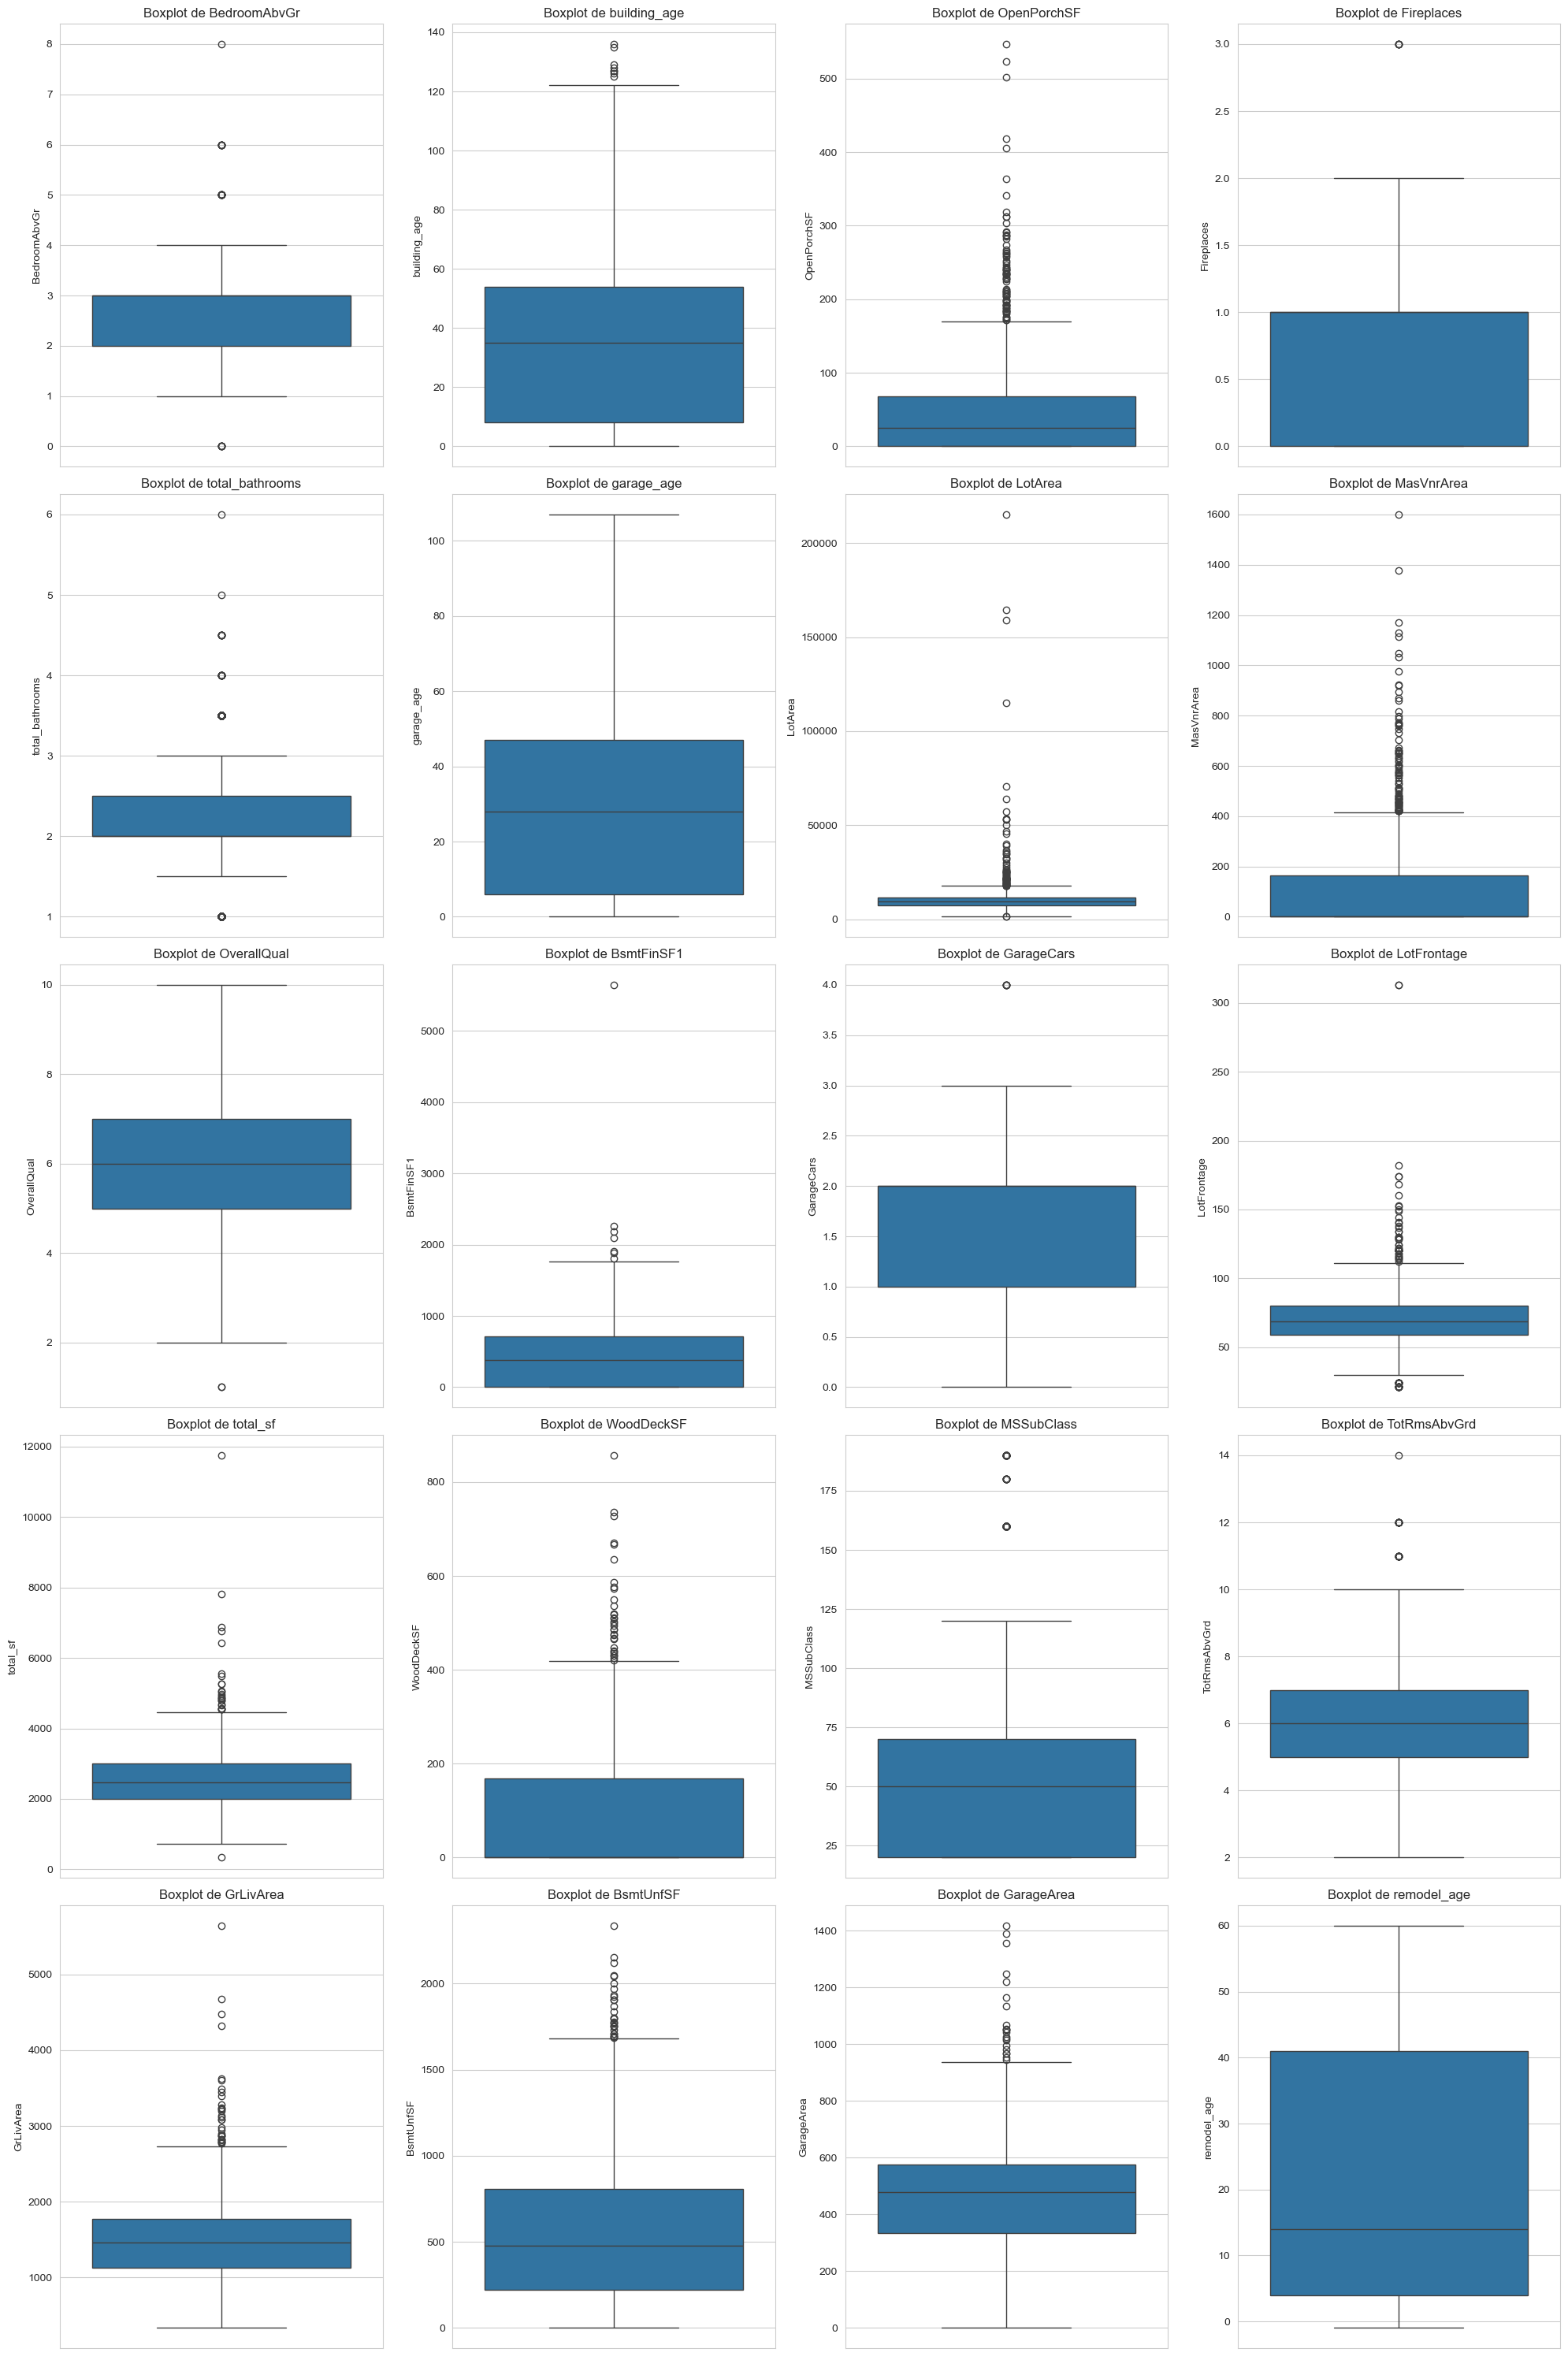

In [ ]:
import math

# Paramètres
features = NEW_NUMS_COLS
n_cols = 4  # nombre de boxplots par ligne
n_rows = math.ceil(len(features) / n_cols)

# Création des subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
axes = axes.flatten()  # pour accéder aux axes comme une liste

# Tracer les boxplots
for i, feature in enumerate(features):
    if feature in NEW_TRAIN.columns:
        sns.boxplot(y=NEW_TRAIN[feature], ax=axes[i])
        axes[i].set_title(f"Boxplot de {feature}")

# Supprimer les sous-graphiques inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [75]:
for feature in NEW_NUMS_COLS:
    Q1 = NEW_TRAIN[feature].quantile(0.25)
    Q3 = NEW_TRAIN[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    NEW_TRAIN[feature] = NEW_TRAIN[feature].apply(
        lambda x: lower if x < lower else upper if x > upper else x
    )


In [79]:
for feature in NEW_NUMS_COLS:
    Q1 = NEW_TRAIN[feature].quantile(0.25)
    Q3 = NEW_TRAIN[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Vérifie s'il reste des valeurs en dehors des bornes
    outliers = NEW_TRAIN[(NEW_TRAIN[feature] < lower) | (NEW_TRAIN[feature] > upper)]
    if not outliers.empty:
        print(f"Encore des outliers dans la colonne : {feature}")


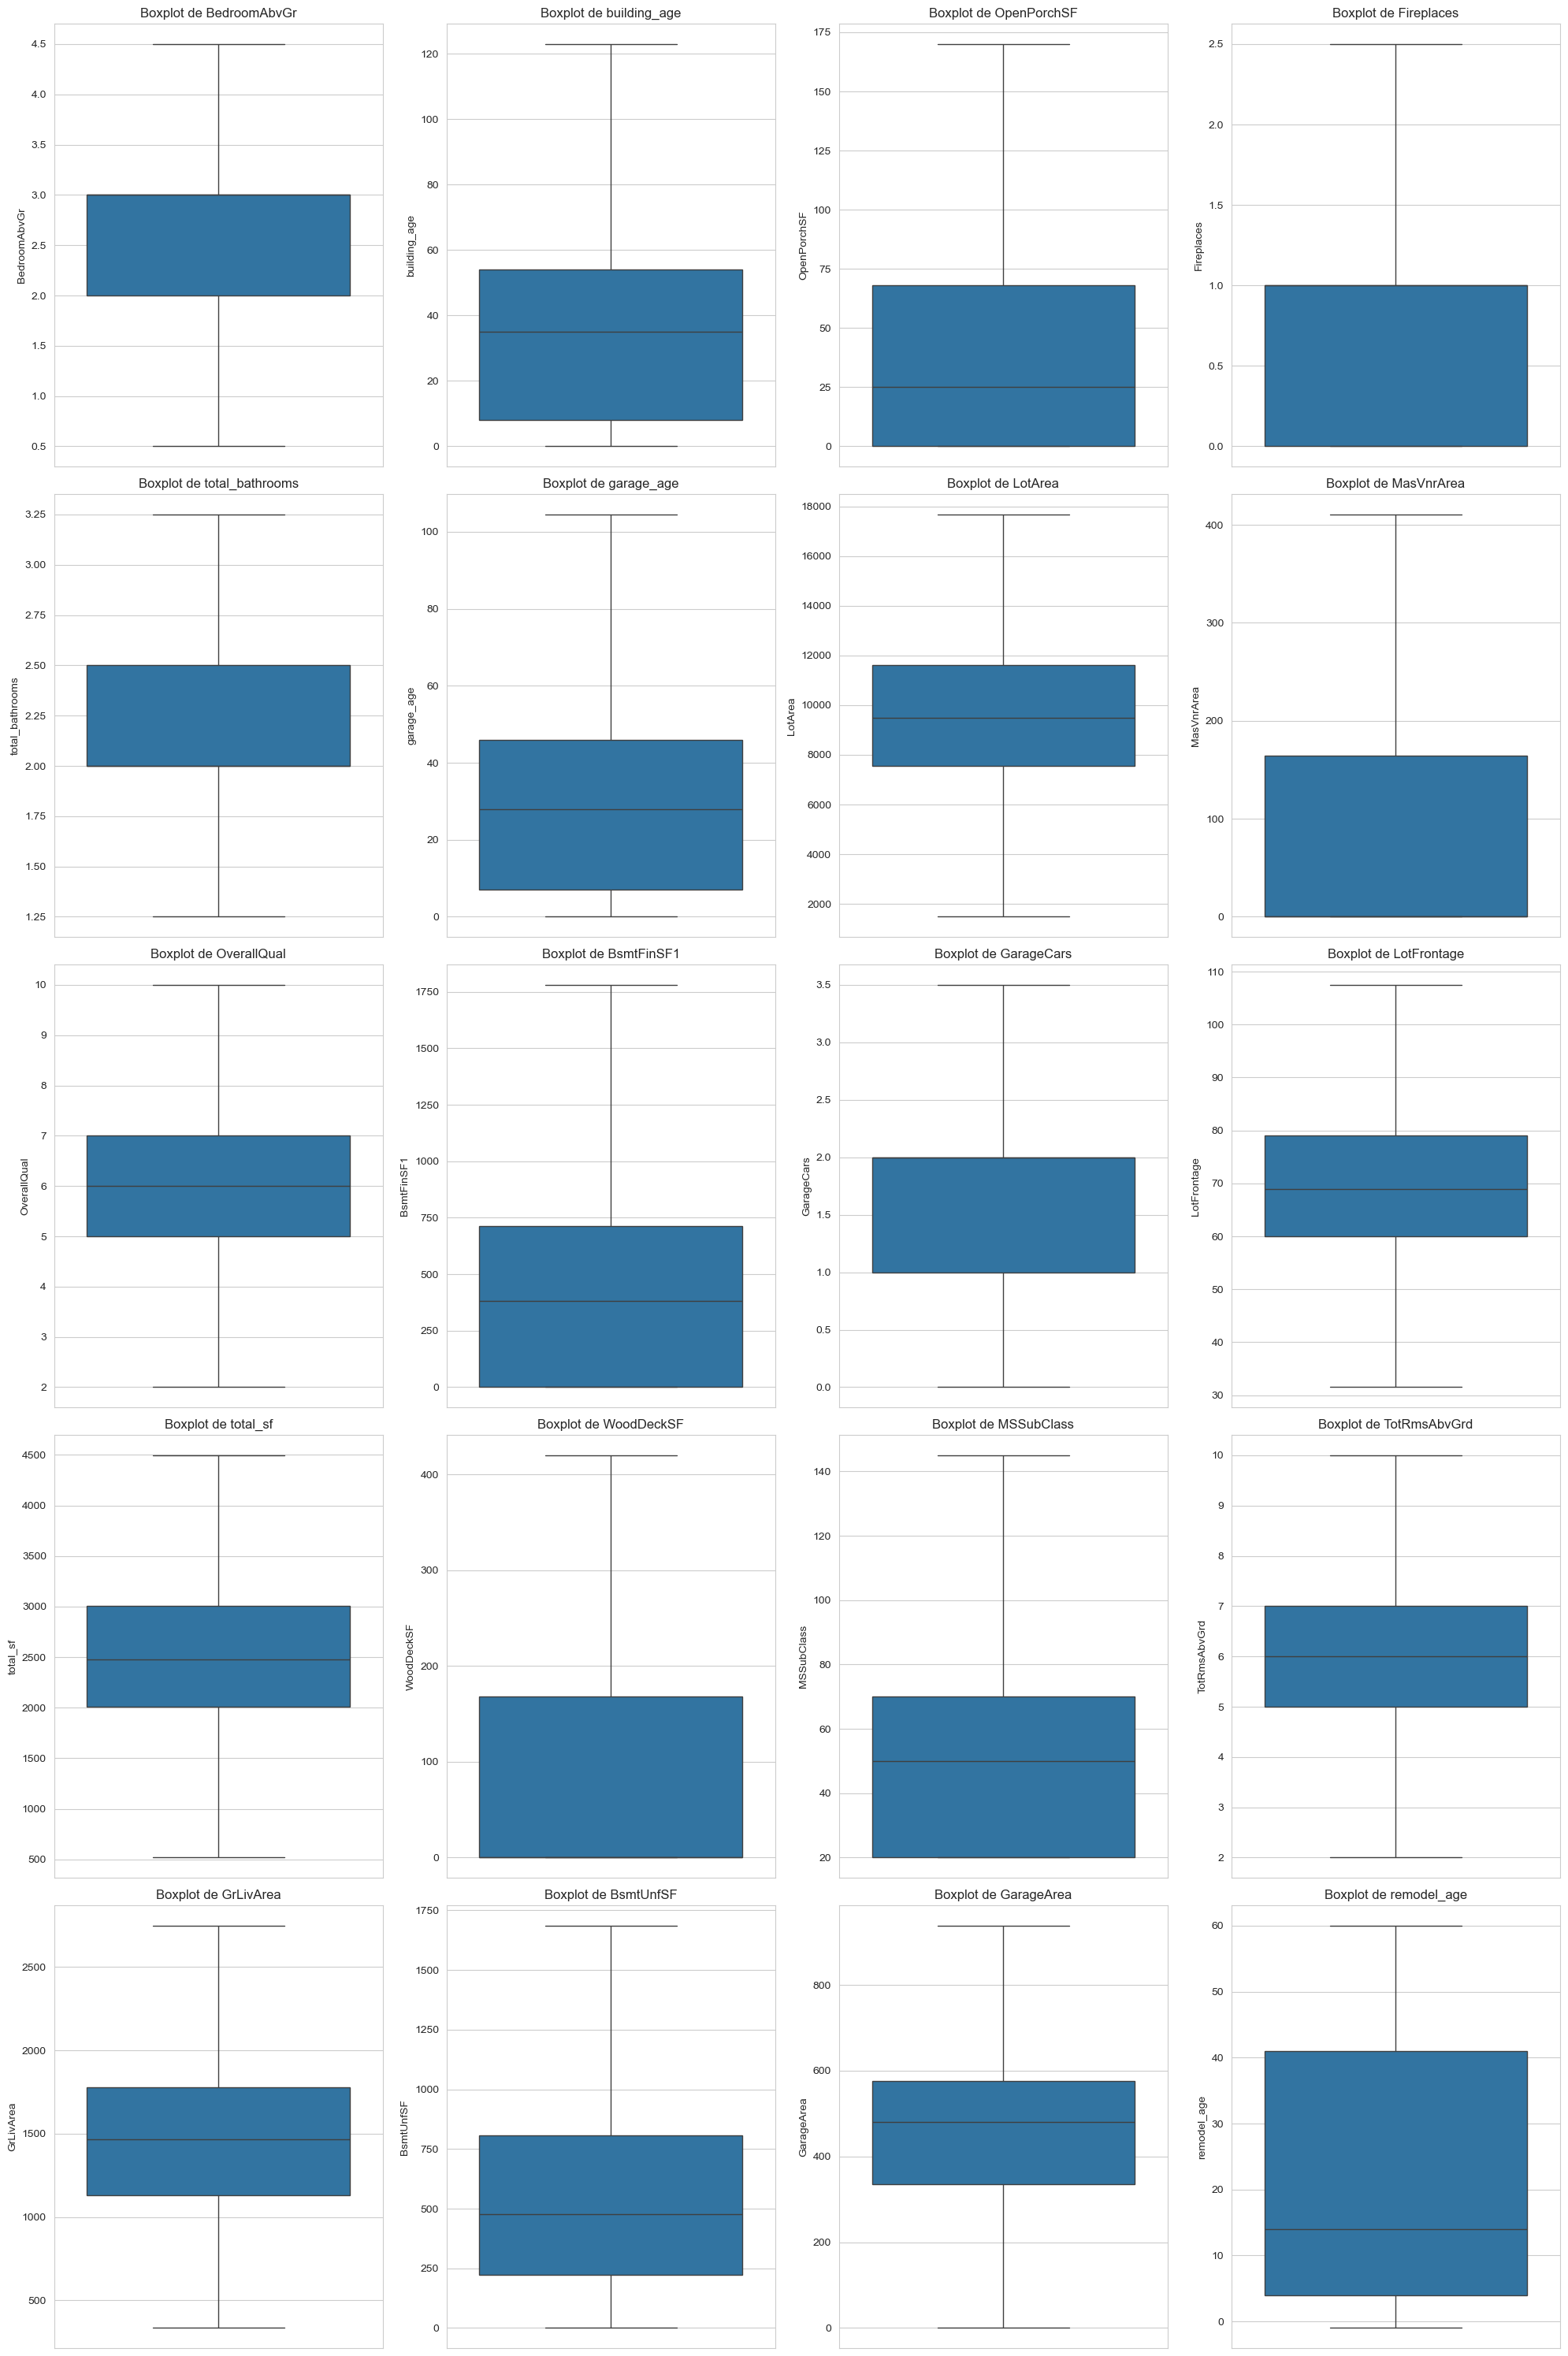

In [81]:
features = NEW_NUMS_COLS
n_cols = 4  # nombre de boxplots par ligne
n_rows = math.ceil(len(features) / n_cols)

# Création des subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
axes = axes.flatten()  # pour accéder aux axes comme une liste

# Tracer les boxplots
for i, feature in enumerate(features):
    if feature in NEW_TRAIN.columns:
        sns.boxplot(y=NEW_TRAIN[feature], ax=axes[i])
        axes[i].set_title(f"Boxplot de {feature}")

# Supprimer les sous-graphiques inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Encodage et standardisation
Objectif : Préparer les données pour la modélisation en encodant les variables catégoriques et en standardisant les variables numériques.

Actions :

Appliquer One-Hot Encoding aux variables catégoriques.
Aligner train et test pour avoir les mêmes colonnes.
Standardiser les variables numériques avec StandardScaler.

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Préparation du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NEW_NUMS_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), NEW_CATS_COLS)
    ]
)


In [92]:
X = NEW_TRAIN.drop(columns=[TARGET_NAME])
y = NEW_TRAIN[TARGET_NAME]

X_train_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(NEW_TEST)

In [93]:
X_train_processed.shape , X_test_processed.shape

((1460, 75), (1459, 75))

### Chargement de données traitées pour les traitements ultérieurs

In [101]:
DATA_DIR

WindowsPath('../src/data/raw')

In [103]:
# Créer le dossier si besoin
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Convertir les tableaux en DataFrame
if hasattr(X_train_processed, "toarray"):
    X_train_df = pd.DataFrame(X_train_processed.toarray())
    X_test_df = pd.DataFrame(X_test_processed.toarray())
else:
    X_train_df = pd.DataFrame(X_train_processed)
    X_test_df = pd.DataFrame(X_test_processed)

# Réinitialiser l'index de y
y_df = pd.DataFrame(y).reset_index(drop=True)

# Sauvegarde dans des fichiers CSV
X_train_df.to_csv(PROCESSED_DIR / "X_train_processed.csv", index=False)
X_test_df.to_csv(PROCESSED_DIR / "X_test_processed.csv", index=False)
y_df.to_csv(PROCESSED_DIR / "y_train.csv", index=False)


---
---